In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import plotly.io as pio
from plotly.subplots import make_subplots
from datasets import load_from_disk
from datetime import datetime
import pandas as pd
import math
from collections import defaultdict
import numpy as np

from transformer_reasoning.train.train_llama import find_question_end


In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"



tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [2]:
def get_queried_attribute(question):
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:  # Look only in last part after 's
            return attr
    return None

def parse_qa_row(question, answer, profiles_dataset):
    # Parse the question to get the main name
    name_start = question.find("What was ") + len("What was ")
    name_end = question.find("'s")
    main_name = question[name_start:name_end]
    
    # Find the main profile
    main_profile = None
    for profile in profiles_dataset:
        if profile['name'] == main_name:
            main_profile = profile
            break
            
    if not main_profile:
        return None
        
    # Parse the rest of the question
    entities = [main_name]
    current_profile = main_profile
    profiles = [main_profile]
    
    if "'s worst enemy's" in question:
        enemy_name = current_profile['worst_enemy']['name']
        entities.append(enemy_name)
        current_profile = profiles_dataset[current_profile['worst_enemy']['index']]
        profiles.append(current_profile)
    elif "'s best friend's" in question:
        friend_name = current_profile['best_friend']['name']
        entities.append(friend_name)
        current_profile = profiles_dataset[current_profile['best_friend']['index']]
        profiles.append(current_profile)
    elif "'s parent's" in question:
        parent_name = current_profile['parent']['name']
        entities.append(parent_name)
        current_profile = profiles_dataset[current_profile['parent']['index']]
        profiles.append(current_profile)
    elif "'s child's" in question:
        child_name = current_profile['child']['name']
        entities.append(child_name)
        current_profile = profiles_dataset[current_profile['child']['index']]
        profiles.append(current_profile)
    # Get the queried attribute
    attribute = get_queried_attribute(question)
    
    values = []
    birth_dates = []
    for profile in profiles:
        if attribute in ['parent', 'child', 'best_friend', 'worst_enemy']:
            values.append((profile['name'], str(profile[attribute]['name'])))
        else:
            values.append((profile['name'], str(profile[attribute])))
        
        birth_dates.append((profile['name'], profile['birth_date']))

    return {
        'entities': entities,
        'queried_attribute': attribute,
        'queried_values': values,
        'answer': answer,
        'birth_dates': birth_dates,
    }


In [36]:
# Load datasets
%pdb on

def get_avg_logit_difference(num_samples=128, split='heldout_profiles', N=10000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")

    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")


    base_rates = {}
    df = pd.read_csv(f'answer_distributions_{N//1000}k.csv')
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        attr_df = df[df['attribute'] == attr]
        total = attr_df['count'].sum()
        base_rates[attr] = {row['answer']: row['count']/total for _, row in attr_df.iterrows()}

    unique_answers = {}
    unique_answer_groups = {}

    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(' ' + p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        token_groups = defaultdict(list)
        for ans in unique_answers[attr]:
            first_token = tokenizer.encode(' ' + ans, add_special_tokens=False)[0]
            token_groups[first_token].append(ans)
        
        unique_answers[attr] = list(token_groups.keys())
        unique_answer_groups[attr] = token_groups
        
        # Sum base rates for answers with same first token
        merged_base_rates = defaultdict(float)
        for token, answers in token_groups.items():
            for ans in answers:
                merged_base_rates[token] += base_rates[attr].get(ans, 0)
        base_rates[attr] = {k: v for k, v in merged_base_rates.items() if v > 0}


    results = {
        'order': [],
        'model_order': [],
        'checkpoint': [],
        'question': [],
        'answer': [],
        'queried_attribute': [],
        'model_logprob': [],
        'base_rate_logprob': [],
        'uniform_logprob': [],
        'all_logprob': [],
        'logit_diff': [],
        'is_correct': [],
        'rank': [],
    }

    for order in [2]:
        qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
        for model_order in [2]:
            for suffix in ['continued_2', 'continued_3', 'infinite']:
                base_dir = Path(f"results/n{N}_p1000000_o{model_order}_{suffix}")
                checkpoints = list(base_dir.glob("checkpoint-*"))
                for checkpoint in checkpoints[::5]:
                    checkpoint_path = Path(f"{base_dir}/checkpoint-{checkpoint}")
                    if not checkpoint_path.exists():
                        continue

                    model = AutoModelForCausalLM.from_pretrained(
                        checkpoint_path,
                        torch_dtype=torch.bfloat16, 
                        device_map="cuda",
                    )

                    for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
                        batch_samples = qa_dataset_filtered[split][i:i+batch_size]
                        
                        questions = [f"<|endoftext|>Question: {sample} Answer:" for sample in batch_samples['questions.question']]
                        answers = [' ' + sample for sample in batch_samples['questions.answer']]
                        queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
                        answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
                        
                        inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
                        with torch.no_grad():
                            outputs = model(**inputs)
                        
                        for j, (question, answer, answer_token, queried_attribute) in enumerate(zip(
                                batch_samples['questions.question'], 
                                batch_samples['questions.answer'],
                                answer_tokens, 
                                queried_attributes)):
                            comparison_tokens = unique_answers[queried_attribute]
                            answer_index = comparison_tokens.index(answer_token)
                            
                            next_token_logprobs = outputs.logits[j, -1, comparison_tokens].log_softmax(dim=-1)
                            next_token_logits = outputs.logits[j, -1, comparison_tokens]
                            answer_logprob = next_token_logprobs[answer_index].item()
                            answer_logit = next_token_logits[answer_index].item()
                            
                            # Calculate rank
                            sorted_logits, indices = next_token_logprobs.sort(descending=True)
                            rank = (indices == answer_index).nonzero().item()
                            
                            # Base rate logprob
                            base_rate_logprob = math.log(base_rates[queried_attribute].get(answer_token, 1/len(comparison_tokens)))
                            
                            # Store individual results
                            results['order'].append(order)
                            results['model_order'].append(model_order)
                            results['checkpoint'].append(checkpoint)
                            results['question'].append(question)
                            results['answer'].append(answer)
                            results['model_logprob'].append(answer_logprob)
                            results['base_rate_logprob'].append(base_rate_logprob)
                            results['uniform_logprob'].append(math.log(1/len(comparison_tokens)))
                            results['all_logprob'].append(math.log(1/next_token_logprobs.shape[-1]))
                            results['logit_diff'].append(answer_logit - next_token_logits.mean().item())
                            results['is_correct'].append(1 if answer_logprob == next_token_logprobs.max() else 0)
                            results['rank'].append(rank / len(sorted_logits))

                    print(f"Processed checkpoint {checkpoint} for order {order}, model order {model_order}")
                
    return results


Automatic pdb calling has been turned ON


In [37]:
results = get_avg_logit_difference(num_samples=100, split='heldout_profiles', N=10000)


Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [38]:
results_train = get_avg_logit_difference(num_samples=100, split='train', N=10000)


Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [39]:
results_train_25k = get_avg_logit_difference(num_samples=100, split='train', N=25000)


Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [40]:
results25 = get_avg_logit_difference(num_samples=100, split='heldout_profiles', N=25000)

Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [41]:
del results['queried_attribute']
del results25['queried_attribute']
del results_train['queried_attribute']
del results_train_25k['queried_attribute']

results = pd.DataFrame(results)
results['split'] = 'heldout_profiles'
results['N'] = 10000

results25 = pd.DataFrame(results25)
results25['split'] = 'heldout_profiles'
results25['N'] = 25000

results_train = pd.DataFrame(results_train)
results_train['split'] = 'train'
results_train['N'] = 10000

results_train_25k = pd.DataFrame(results_train_25k)
results_train_25k['split'] = 'train'
results_train_25k['N'] = 25000

all_results = pd.concat([results, results25, results_train, results_train_25k])
all_results

,order,model_order,checkpoint,question,answer,model_logprob,base_rate_logprob,uniform_logprob,all_logprob,logit_diff,is_correct,rank,split,N
0,1,1,10000,What was Shari Steffanie Luikart's worst enemy?,Roselle Dot Naftali,-0.003499,-5.077671,-7.457032,-7.457032,20.711145,1,0.000000,heldout_profiles,10000
1,1,1,10000,What was Shari Steffanie Luikart's employer?,Garuda Indonesia,-0.079812,-4.193666,-4.060443,-4.060443,12.693090,1,0.000000,heldout_profiles,10000
2,1,1,10000,What was Shari Steffanie Luikart's university?,Nanjing Agricultural University,-0.016758,-2.845247,-3.912023,-3.912023,14.410625,1,0.000000,heldout_profiles,10000
3,1,1,10000,What was Shari Steffanie Luikart's best friend?,Jeannine Many Drapeaux,-8.842524,-6.776811,-7.457032,-7.457032,0.143317,0,0.469977,heldout_profiles,10000
4,1,1,10000,What was Shari Steffanie Luikart's child?,Cheyenne Starla Kasson,-9.278306,-7.234177,-7.234177,-7.234177,-1.172589,0,0.829726,heldout_profiles,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307,2,2,1010000,What was Von Lida Luzar's worst enemy's worst ...,Von Lida Luzar,-7.978604,-7.823092,-7.571474,-7.571474,0.161992,0,0.346035,train,25000
13308,2,2,1010000,What was Zonia Shawanda Shigemitsu's worst ene...,Beatris Esperanza Moricca,-7.508850,-7.495233,-7.522400,-7.522400,0.675797,0,0.189832,train,25000
13309,2,2,1010000,What was Sondra Holly Henle's best friend's bi...,2082-08-28,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,train,25000
13310,2,2,1010000,What was Kate Woodrow Holgate's worst enemy's ...,"Bourke, New South Wales",-3.592507,-5.421702,-5.214936,-5.214936,2.402514,0,0.038043,train,25000


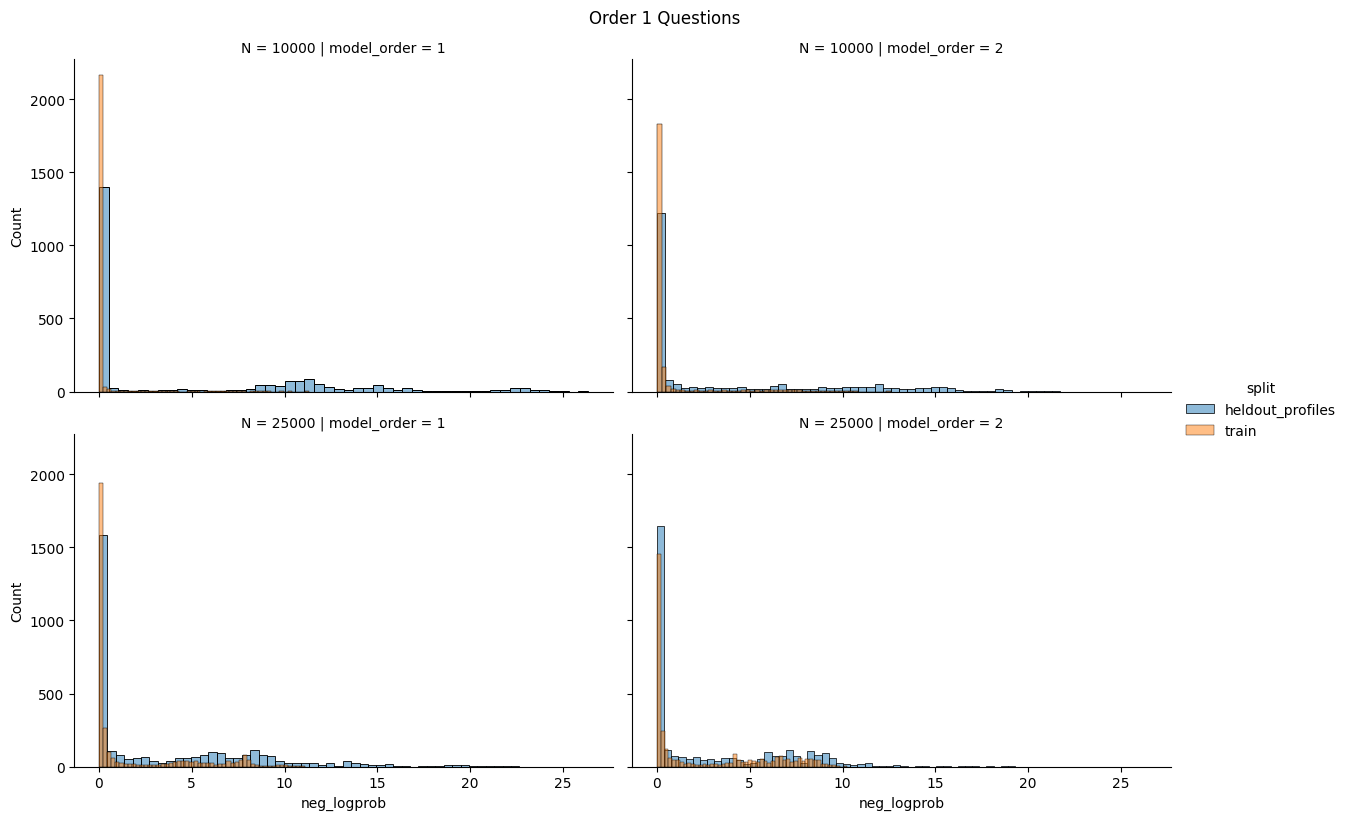

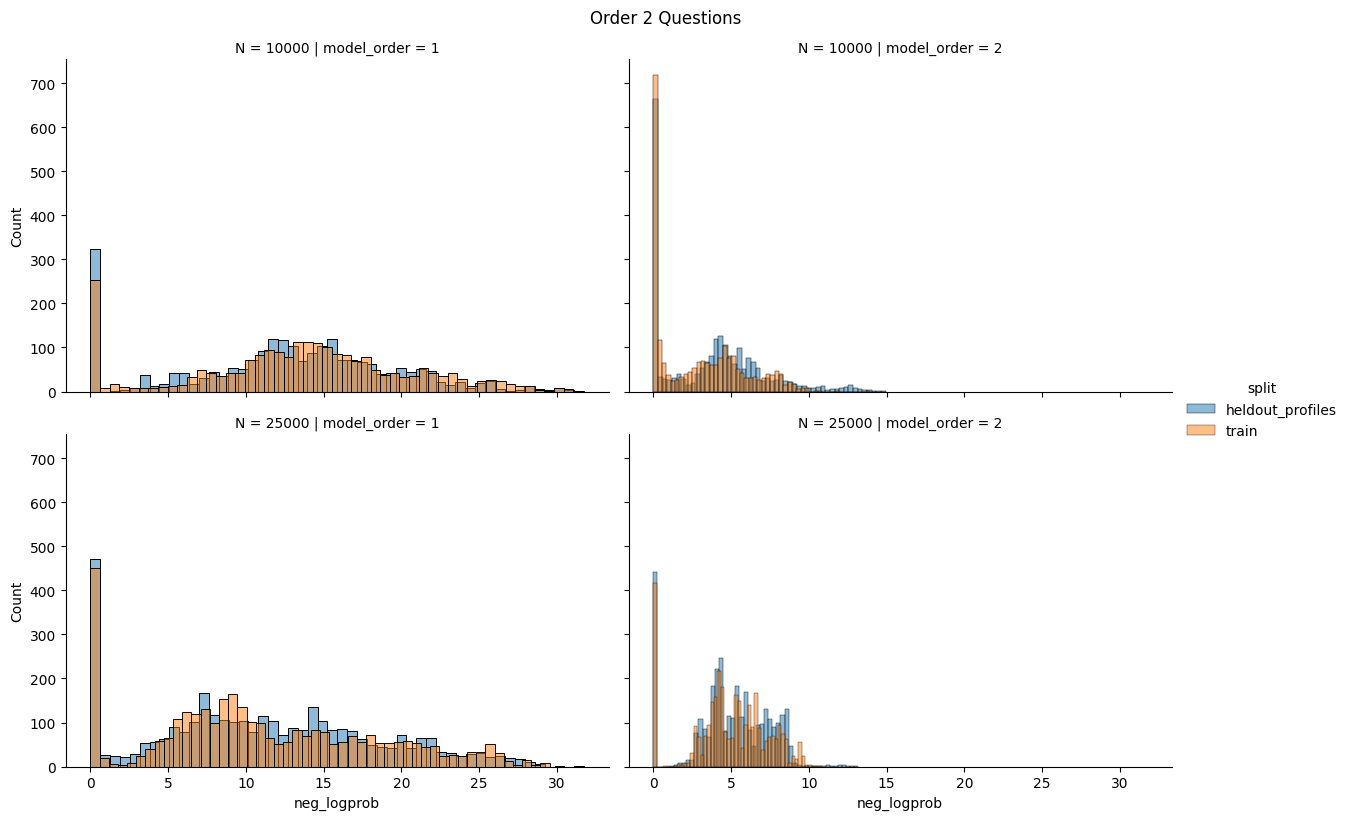

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
# Add the negative log prob column first
all_results['neg_logprob'] = -all_results['model_logprob']
all_results['neg_base_logprob'] = -all_results['base_rate_logprob']

# Create the plot
for order in [1, 2]:
    data = all_results[all_results['order'] == order]
    
    g = sns.FacetGrid(data, 
                      row='N', 
                      col='model_order',
                      hue='split',
                      height=4,
                      aspect=1.5)

    g.map(sns.histplot, 'neg_logprob', bins=50, alpha=0.5)  # y-axis log scale
    g.add_legend()
    plt.suptitle(f'Order {order} Questions', y=1.02)
    plt.show()

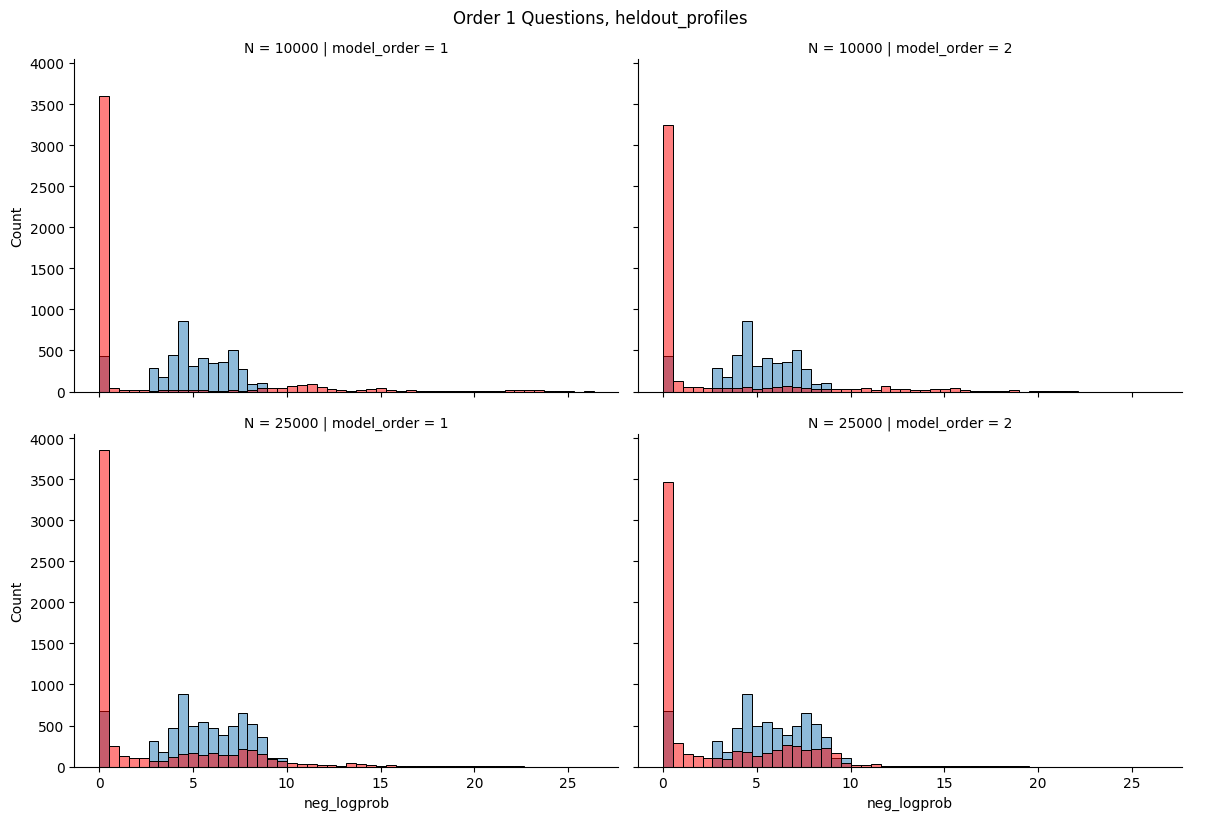

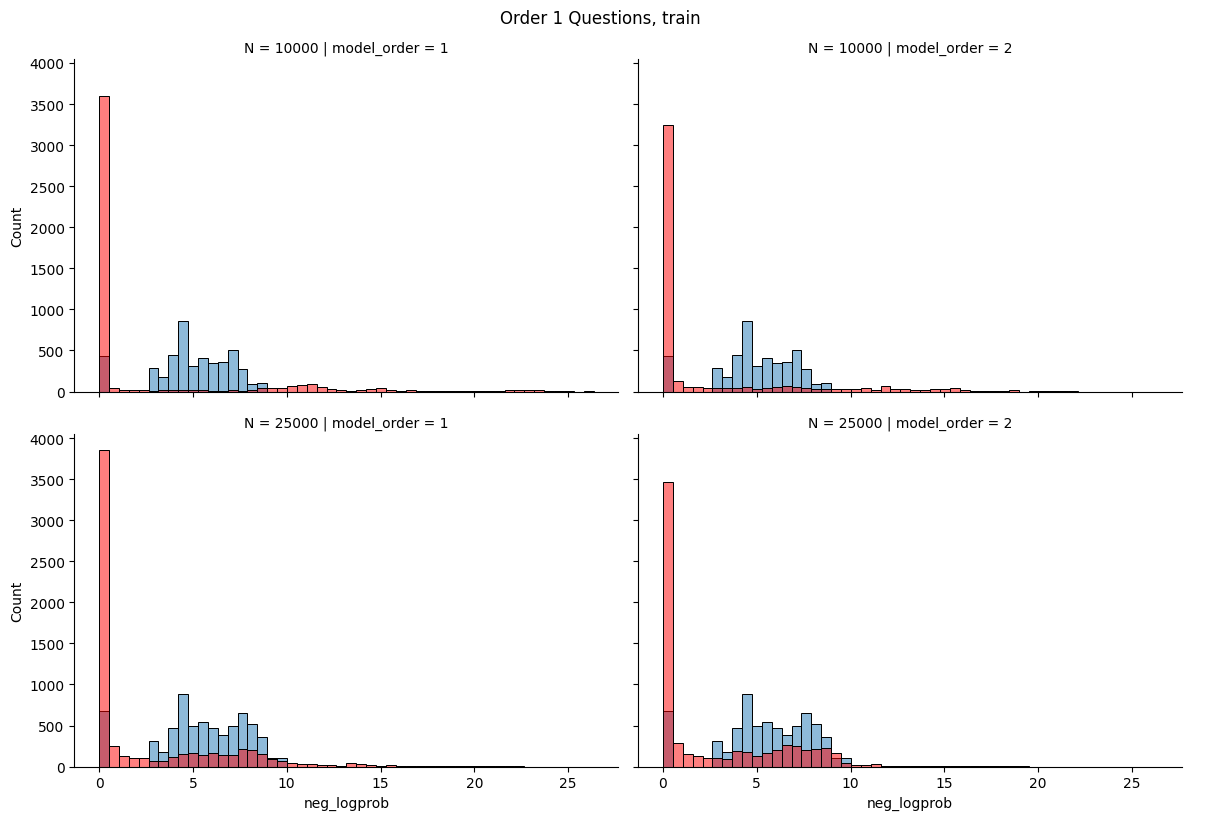

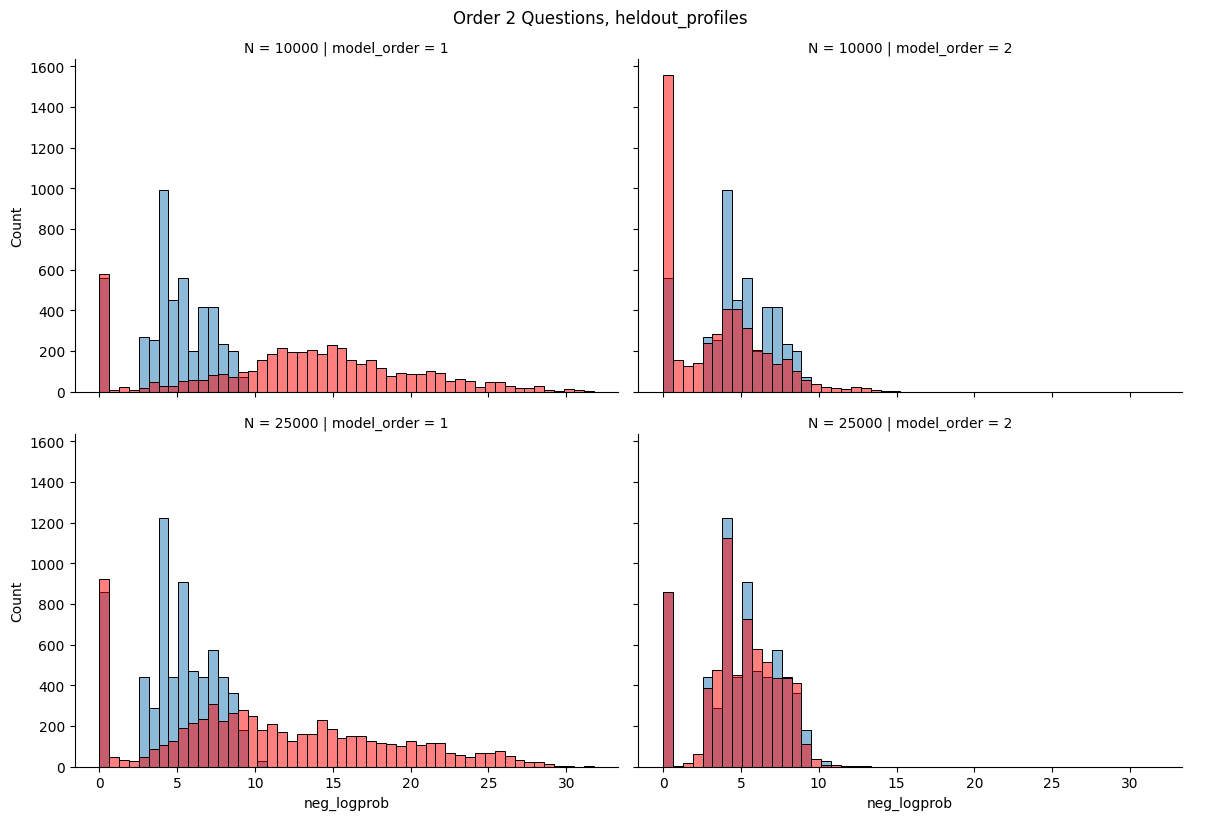

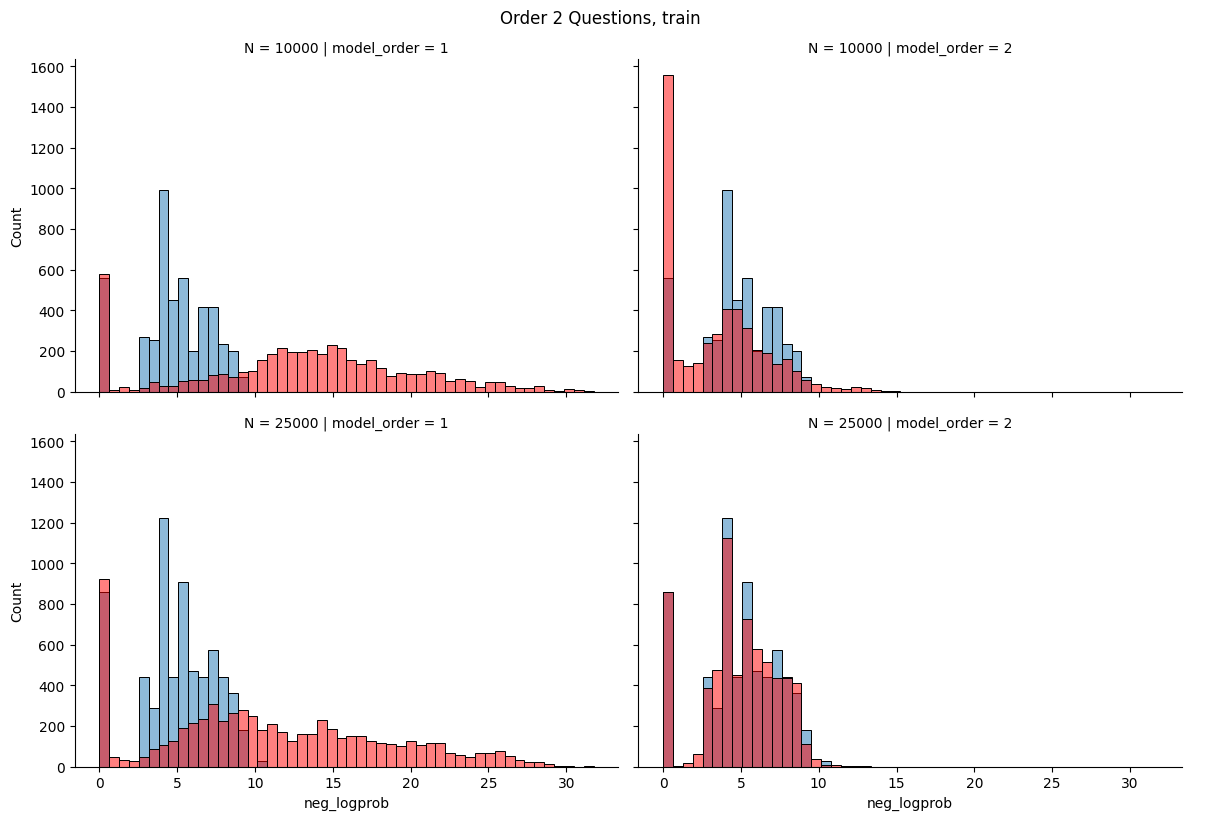

In [59]:
for order in [1, 2]:
    for split in ['heldout_profiles', 'train']:
        data = all_results[all_results['order'] == order]
        
        min_val = min(data['neg_base_logprob'].min(), data['neg_logprob'].min())
        max_val = max(data['neg_base_logprob'].max(), data['neg_logprob'].max())
        bins = np.linspace(min_val, max_val, 51)  # 51 edges = 50 bins
        
        g = sns.FacetGrid(data, 
                        row='N', 
                        col='model_order',
                        height=4,
                        aspect=1.5)

        g.map(sns.histplot, 'neg_base_logprob', bins=bins, alpha=0.5)  # y-axis log scale
        g.map(sns.histplot, 'neg_logprob', bins=bins, alpha=0.5, color='red')
        g.add_legend()
        plt.suptitle(f'Order {order} Questions, {split}', y=1.02)
        plt.show()

In [47]:
samples = all_results[
    (all_results['order'] == 2) & 
    (all_results['N'] == 25000) & 
    (all_results['neg_logprob'] < 0.1)
][['question', 'answer', 'neg_logprob', 'model_order', 'checkpoint', 'split', 'base_rate_logprob']]
samples.head(20)

,question,answer,neg_logprob,model_order,checkpoint,split,base_rate_logprob
6658,What was Benedict Glynda Kerper's child's birt...,1908-04-19,-0.000000,1,10000,heldout_profiles,0.000000
6680,What was Vera Cherrie Paterson's child's birth...,2097-02-26,-0.000000,1,10000,heldout_profiles,0.000000
6683,What was Leroy Virgen Raugust's worst enemy's ...,2011-03-23,-0.000000,1,10000,heldout_profiles,0.000000
6690,What was Anamaria Leah Kitanik's parent's birt...,1942-09-28,-0.000000,1,10000,heldout_profiles,0.000000
6700,What was Letitia Lorena Tease's worst enemy's ...,1923-09-28,-0.000000,1,10000,heldout_profiles,0.000000
6703,What was Missy Laurette Carpinteyro's best fri...,2022-06-16,-0.000000,1,10000,heldout_profiles,0.000000
6710,What was Art Christoper Pesek's best friend's ...,2025-10-11,-0.000000,1,10000,heldout_profiles,0.000000
6718,What was Rasheeda Elizabeth Simler's worst ene...,2066-01-15,-0.000000,1,10000,heldout_profiles,0.000000
6726,What was Pearlene Leisa Mantini's worst enemy'...,2025-05-25,-0.000000,1,10000,heldout_profiles,0.000000
6732,What was Tarsha Krystyna Twilley's worst enemy...,2022-02-05,-0.000000,1,10000,heldout_profiles,0.000000


In [48]:
samples = all_results[
    (all_results['model_order'] == 2) & 
    (all_results['order'] == 2) & 
    (all_results['N'] == 25000) & 
    (all_results['neg_logprob'] < 0.1)
][['question', 'answer', 'neg_logprob', 'model_order', 'checkpoint', 'split', 'base_rate_logprob']]
samples.head(20)

,question,answer,neg_logprob,model_order,checkpoint,split,base_rate_logprob
9986,What was Benedict Glynda Kerper's child's birt...,1908-04-19,-0.0,2,10000,heldout_profiles,0.0
10008,What was Vera Cherrie Paterson's child's birth...,2097-02-26,-0.0,2,10000,heldout_profiles,0.0
10011,What was Leroy Virgen Raugust's worst enemy's ...,2011-03-23,-0.0,2,10000,heldout_profiles,0.0
10018,What was Anamaria Leah Kitanik's parent's birt...,1942-09-28,-0.0,2,10000,heldout_profiles,0.0
10028,What was Letitia Lorena Tease's worst enemy's ...,1923-09-28,-0.0,2,10000,heldout_profiles,0.0
10031,What was Missy Laurette Carpinteyro's best fri...,2022-06-16,-0.0,2,10000,heldout_profiles,0.0
10038,What was Art Christoper Pesek's best friend's ...,2025-10-11,-0.0,2,10000,heldout_profiles,0.0
10046,What was Rasheeda Elizabeth Simler's worst ene...,2066-01-15,-0.0,2,10000,heldout_profiles,0.0
10054,What was Pearlene Leisa Mantini's worst enemy'...,2025-05-25,-0.0,2,10000,heldout_profiles,0.0
10060,What was Tarsha Krystyna Twilley's worst enemy...,2022-02-05,-0.0,2,10000,heldout_profiles,0.0


In [55]:
all_results[
    (all_results['order'] == 2) & 
    (all_results['N'] == 10000) & 
    (all_results['model_order'] == 2)
]['base_rate_logprob'].median()

-4.734799309696188

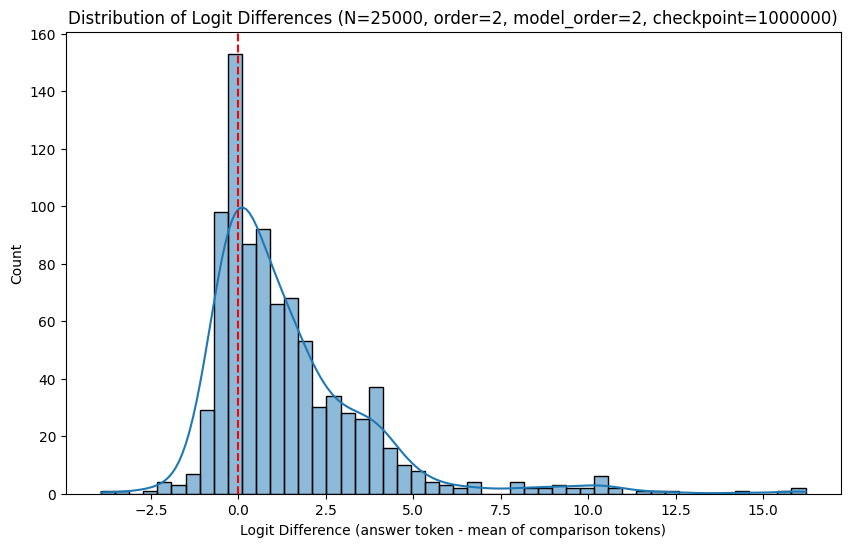

1.429804576042644


In [10]:
def get_logit_differences(num_samples=128, split='heldout_profiles', N=10000, order=1, model_order=1, checkpoint=50000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")
    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")
    
    # Get unique answers and groups (same as in your original code)
    unique_answers = {}
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        token_groups = defaultdict(list)
        for ans in unique_answers[attr]:
            first_token = tokenizer.encode(' ' + ans, add_special_tokens=False)[0]
            token_groups[first_token].append(ans)
        
        unique_answers[attr] = list(token_groups.keys())
    
    # Filter dataset
    qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
    
    # Load model
    checkpoint_path = Path(f"results/n{N}_p1000000_o{model_order}_continued_2/checkpoint-{checkpoint}")
    model = AutoModelForCausalLM.from_pretrained(
        checkpoint_path,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
    )
    
    logit_differences = []
    
    for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
        batch_samples = qa_dataset_filtered[split][i:i+batch_size]
        
        questions = [f"Question: {sample} Answer:" for sample in batch_samples['questions.question']]
        answers = [' ' + sample for sample in batch_samples['questions.answer']]
        queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
        answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
        
        inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        for j, (answer_token, queried_attribute) in enumerate(zip(answer_tokens, queried_attributes)):
            comparison_tokens = unique_answers[queried_attribute]
            next_token_logits = outputs.logits[j, -1, :]  # Raw logits
            
            answer_logit = next_token_logits[answer_token].item()
            comparison_logits = next_token_logits[comparison_tokens]
            other_logits_mean = (comparison_logits.sum() - answer_logit) / (len(comparison_tokens) - 1)
            logit_differences.append(answer_logit - other_logits_mean.item())
    
    # Plot distribution using seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    sns.histplot(logit_differences, kde=True, bins=50)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Distribution of Logit Differences (N={N}, order={order}, model_order={model_order}, checkpoint={checkpoint})')
    plt.xlabel('Logit Difference (answer token - mean of comparison tokens)')
    plt.ylabel('Count')
    plt.show()
    return logit_differences

logit_diffs = get_logit_differences(num_samples=1000, order=2, model_order=2, checkpoint=1000000, N=25000)
print(np.nanmean(logit_diffs))

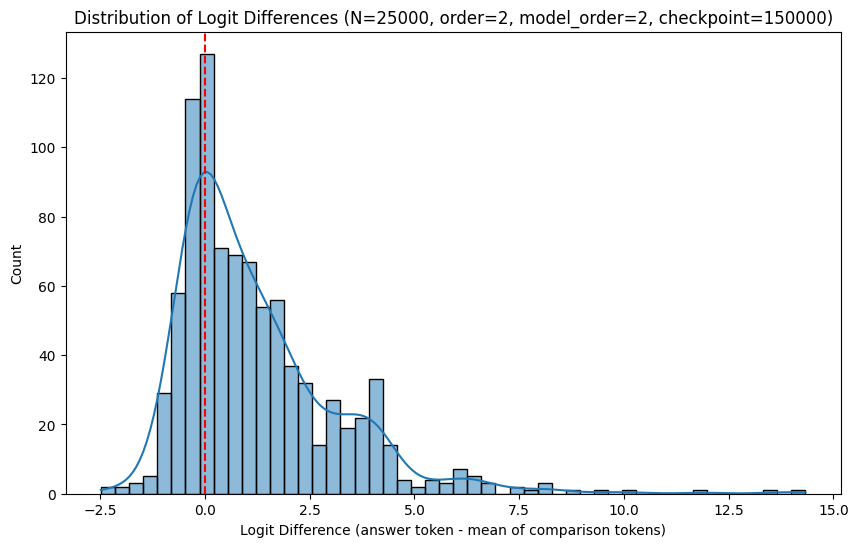

1.2311345446709148


In [11]:
logit_diffs = get_logit_differences(num_samples=1000, order=2, model_order=2, checkpoint=150000, N=25000)
print(np.nanmean(logit_diffs))

In [14]:
rt25k = pd.DataFrame(results_train_25k)
sns.histplot(rt25k['logit_diff'], kde=True, bins=50)

,order,model_order,checkpoint,accuracy,avg_rank,model_avg_logprob,base_rate_avg_logprob,base_rate_median_logprob,model_median_logprob,base_rate_accuracy,base_rate_avg_rank,uniform_avg_logprob,all_avg_logprob,logit_diff
0,1,1,10000,0.553711,0.076374,-2.767686,-5.223632,-5.407909,-0.707783,0.0,0.217735,-5.810687,-5.810687,8.551385
1,1,1,20000,0.572266,0.072033,-2.671089,-5.223632,-5.407909,-0.481876,0.0,0.217735,-5.810687,-5.810687,8.810548
2,1,1,30000,0.588867,0.068262,-2.591861,-5.223632,-5.407909,-0.383219,0.0,0.217735,-5.810687,-5.810687,9.088352
3,1,1,40000,0.593750,0.064293,-2.522591,-5.223632,-5.407909,-0.275599,0.0,0.217735,-5.810687,-5.810687,9.278199
4,1,1,50000,0.610352,0.063839,-2.455092,-5.223632,-5.407909,-0.243276,0.0,0.217735,-5.810687,-5.810687,9.381542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2,2,1000000,0.165039,0.209162,-4.881688,-5.042739,-5.294829,-5.048563,0.0,0.229135,-5.571926,-5.571926,1.365787
412,2,2,1010000,0.168945,0.209408,-4.887267,-5.042739,-5.294829,-5.121779,0.0,0.229135,-5.571926,-5.571926,1.370631
413,2,2,1020000,0.169922,0.210855,-4.876812,-5.042739,-5.294829,-5.049951,0.0,0.229135,-5.571926,-5.571926,1.371390
414,2,2,1030000,0.166992,0.207487,-4.880501,-5.042739,-5.294829,-5.088073,0.0,0.229135,-5.571926,-5.571926,1.350753


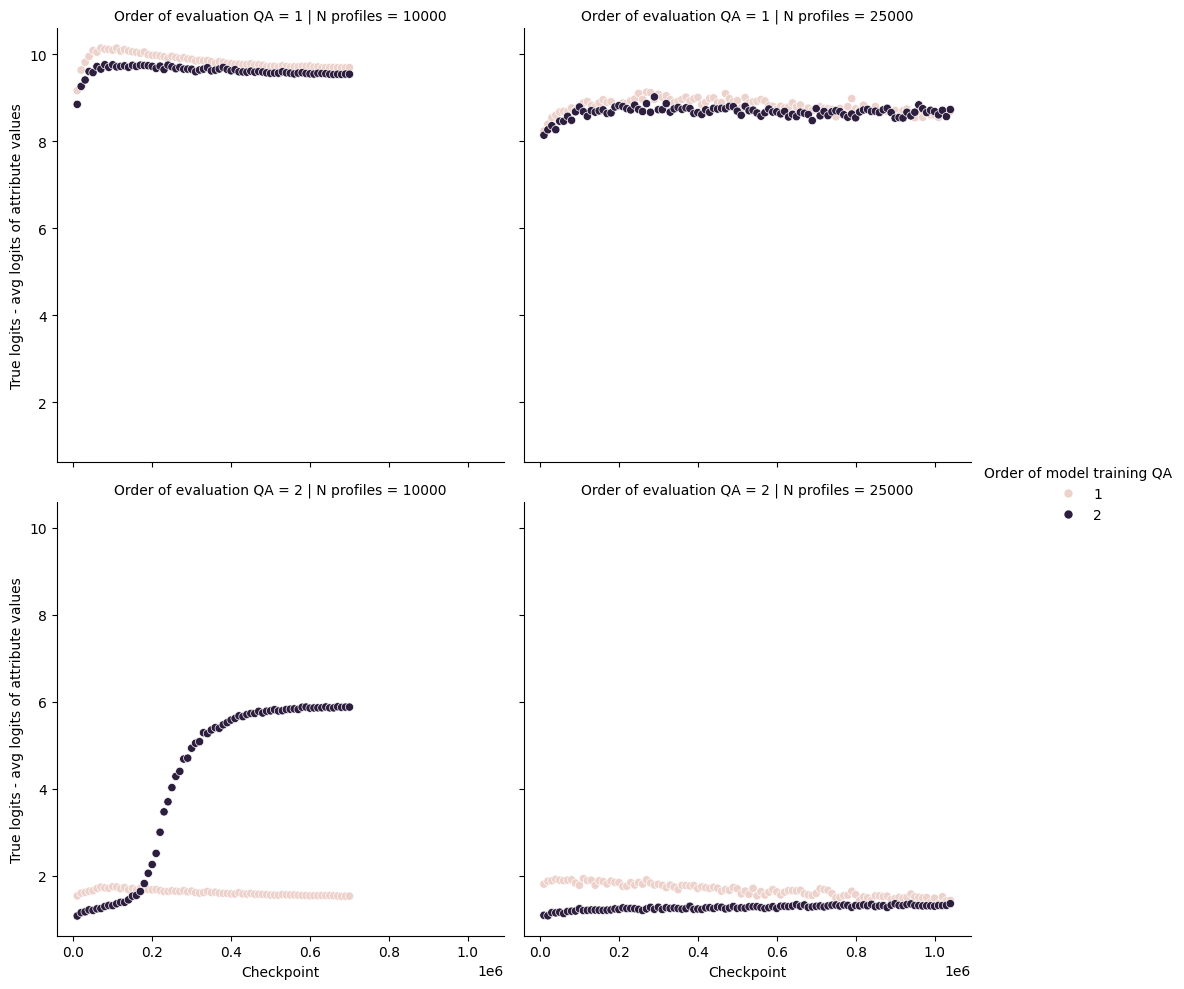

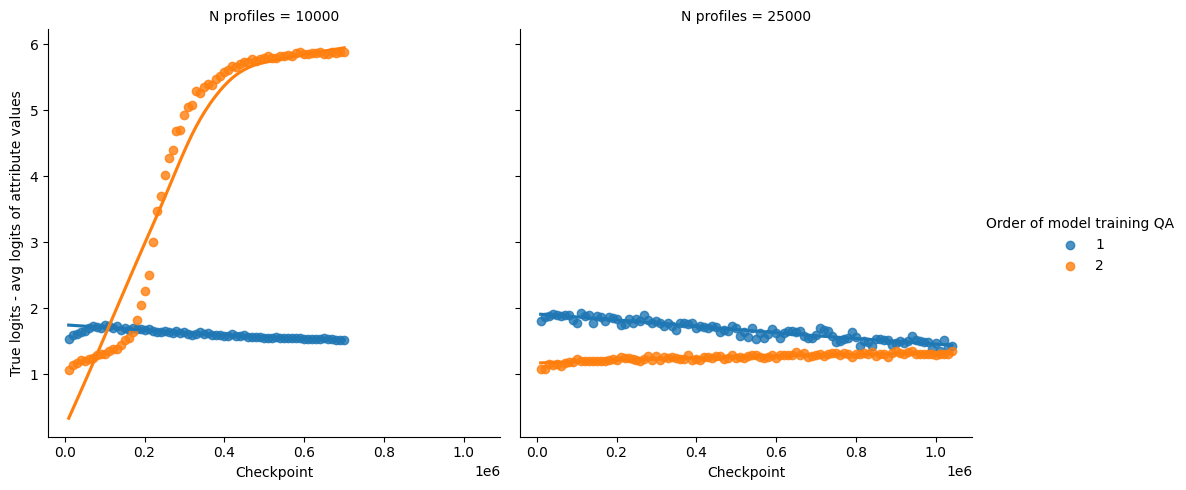

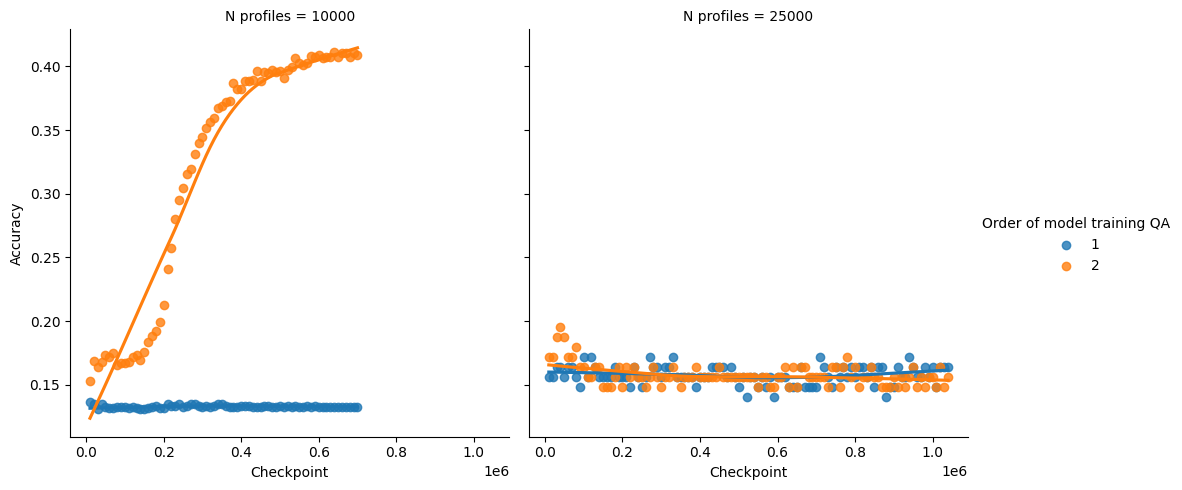

In [9]:
import pandas as pd
import seaborn as sns
results_df = pd.DataFrame(results)
results_df25 = pd.DataFrame(results25)

results_df['N profiles'] = 10000
results_df25['N profiles'] = 25000

results_df = results_df.merge(results_df25, on=['order', 'model_order', 'checkpoint', 'N profiles', 'logit_diff', 'accuracy', 'avg_rank'], how='outer', suffixes=('_10k', '_25k'))
results_df.rename(columns={
    'logit_diff': 'True logits - avg logits of attribute values', 
    'accuracy': 'Accuracy',
    'avg_rank': 'Average fractional rank',
    'checkpoint': 'Checkpoint',
    'order': 'Order of evaluation QA',
    'model_order': 'Order of model training QA',
}, inplace=True)

results_df.to_csv('avg_logit_diff.csv', index=False)
results_df = pd.read_csv('avg_logit_diff.csv')

sns.relplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df, hue='Order of model training QA', 
    row='Order of evaluation QA', 
    col='N profiles', 
)

sns.lmplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df[(results_df['Order of evaluation QA'] == 2)], 
    hue='Order of model training QA', 
    col='N profiles',
    lowess=True,
)


sns.lmplot(
    x='Checkpoint', 
    y='Accuracy', 
    data=results_df[(results_df['Order of evaluation QA'] == 2)], 
    hue='Order of model training QA', 
    col='N profiles',
    lowess=True,
)

In [123]:
[(k,len(v)) for k, v in results.items()]

[('order', 140),
 ('model_order', 140),
 ('checkpoint', 140),
 ('accuracy', 140),
 ('avg_rank', 140),
 ('model_avg_logprob', 140),
 ('base_rate_avg_logprob', 140),
 ('base_rate_median_logprob', 140),
 ('model_median_logprob', 140),
 ('base_rate_accuracy', 140),
 ('base_rate_avg_rank', 140),
 ('uniform_avg_logprob', 140),
 ('all_avg_logprob', 140),
 ('logit_diff', 140)]

In [21]:

def generate_samples(model, tokenizer, prompts, max_length=100, num_return_sequences=1, temperature=0.7, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    
    # Decode and clean up the generated sequences
    generated_texts = []
    for sequence in outputs:
        text = tokenizer.decode(sequence, skip_special_tokens=True)
        generated_texts.append(text)
    
    return generated_texts


In [153]:
from src.transformer_reasoning.train.train_utils import create_model_and_tokenizer
from src.transformer_reasoning.train.train_llama import load_and_prepare_datasets

model, tokenizer, real_num_params = create_model_and_tokenizer(500000)
model = AutoModelForCausalLM.from_pretrained(
    "results/n10000_p435888_omin1_omax1_wd0.1_infinite/checkpoint-200000",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)
train_dataset, heldout_dataset = load_and_prepare_datasets(
        tokenizer, None, 10000, 1, [1]
    )


i = iter(train_dataset)
qa_prompts = [next(i) for _ in range(10)]


Model has 435888 parameters


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [190]:
print(qa_prompts[0]['text'][:60])
print(qa_prompts[0]['text'][:79])
tokenizer.decode(qa_prompts[0]['input_ids'][:21], skip_special_tokens=True)

Question: What was Loree Majorie Curtis's birth city? Answer
Question: What was Loree Majorie Curtis's birth city? Answer: Roma, Queensland<


"ĠQuestion : ĠWhat Ġwas ĠLor ee ĠMa j orie ĠCur tis 's Ġbirth Ġcity ? ĠAnswer : ĠRoma , ĠQueensland"

In [191]:
encoded = torch.tensor([qa_prompts[0]['input_ids']], dtype=torch.long).to(model.device).reshape(1, -1)
# del encoded['token_type_ids']
with torch.no_grad():
    outputs = model(encoded[:,:20])#, labels=torch.tensor(qa_prompts[0]['labels']).to(model.device).reshape(1, -1))
    logits = outputs.logits[0, -1, :]  # Get logits for next token
    probs = torch.nn.functional.softmax(logits, dim=-1)
    log_probs = torch.log_softmax(logits, dim=-1)
    
    # Get top 20 tokens and their probabilities
    top_probs, top_tokens = torch.topk(probs, k=30)
    
    # Print each token and its probability
    for token, prob, log_prob in zip(top_tokens, top_probs, log_probs[top_tokens]):
        token_str = tokenizer.decode([token])
        print(f"Token: {token_str:20} Prob: {prob:.4f} Log Prob: {log_prob:.4f}")

Token: ĠQueensland          Prob: 0.9908 Log Prob: -0.0092
Token: ĠNew                 Prob: 0.0086 Log Prob: -4.7592
Token: ane                  Prob: 0.0002 Log Prob: -8.7592
Token: ann                  Prob: 0.0002 Log Prob: -8.7592
Token: ĠVictoria            Prob: 0.0001 Log Prob: -9.1342
Token: ĠSouth               Prob: 0.0001 Log Prob: -9.1342
Token: anne                 Prob: 0.0001 Log Prob: -9.6342
Token: esia                 Prob: 0.0000 Log Prob: -11.4467
Token: ĠChina               Prob: 0.0000 Log Prob: -13.2592
Token: an                   Prob: 0.0000 Log Prob: -13.3842
Token: ĠG                   Prob: 0.0000 Log Prob: -13.5092
Token: ĠTasmania            Prob: 0.0000 Log Prob: -13.6342
Token: ?                    Prob: 0.0000 Log Prob: -13.7592
Token: via                  Prob: 0.0000 Log Prob: -13.8217
Token: olyn                 Prob: 0.0000 Log Prob: -14.0717
Token: ana                  Prob: 0.0000 Log Prob: -14.4467
Token: ĠQuestion            Prob: 0.0000 Log Pr

In [183]:
outputs.loss

In [176]:
tokenizer.decode(encoded[0])

"<|endoftext|> ĠQuestion : ĠWhat Ġwas ĠLor ee ĠMa j orie ĠCur tis 's Ġbirth Ġcity ? ĠAnswer : ĠRoma , ĠQueensland <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠMilag ro ĠBian ca ĠBos ley 's Ġuniversity ? ĠAnswer : ĠCommunication ĠUniversity Ġof ĠChina <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠSig ne ĠS ona ĠHus ar 's Ġuniversity ? ĠAnswer : ĠJinan ĠUniversity <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠEnda ĠMarsha ĠHay s l ip 's Ġuniversity ? ĠAnswer : ĠUniversity Ġof ĠScience Ġand ĠTechnology ĠBeijing <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠDia mond ĠEv elina ĠHar lan 's Ġemployer ? ĠAnswer : ĠPetrokimia ĠGresik <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠBur t ĠB enton ĠDu erson 's Ġbest Ġfriend ? ĠAnswer : ĠAle tha ĠApril ĠWin k elman <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠShar maine ĠDani ela ĠRem is 's Ġemployer ? ĠAnswer : ĠIndonesian ĠAerospace <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠBel k is ĠYu k iko ĠMc ar thy 's Ġchild ? ĠAnswer : ĠMag ar et ĠRub ie ĠK amb <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠMad ison

In [181]:
labels = torch.tensor(qa_prompts[0]['labels']).to(model.device)
labels_nonzero = labels[labels != -100]
tokenizer.decode(labels_nonzero)


': ĠRoma , ĠQueensland : ĠCommunication ĠUniversity Ġof ĠChina : ĠJinan ĠUniversity : ĠUniversity Ġof ĠScience Ġand ĠTechnology ĠBeijing : ĠPetrokimia ĠGresik : ĠAle tha ĠApril ĠWin k elman : ĠIndonesian ĠAerospace : ĠMag ar et ĠRub ie ĠK amb : ĠKay ĠC es ar ĠP ri v ado : ĠS ale , ĠVictoria : ĠSat ĠNusapersada : ĠC ody ĠJas mine ĠHol ib augh : ĠPegadaian : ĠFelic ita ĠAgustina ĠVer di : ĠBumi ĠResources : ĠChar ma in ĠKait lyn ĠZ up fer : ĠDonita ĠCher e ĠCo t re au : Ġ208 9 - 11 - 10 : ĠR asha d ĠDel o ise ĠG od own : ĠDan ika ĠPau line ĠDun st an : Ġ208 6 - 07 - 21 : ĠKereta ĠApi ĠIndonesia : ĠIsab ell ĠLaurene ĠDe'

In [55]:
from src.transformer_reasoning.train.train_utils import create_model_and_tokenizer
from src.transformer_reasoning.train.train_llama import load_and_prepare_datasets

model, tokenizer, real_num_params = create_model_and_tokenizer(500000)
model = AutoModelForCausalLM.from_pretrained(
    "results/n10000_p435888_omin1_omax2_wd0.1_infinite/checkpoint-240000",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)
train_dataset, heldout_dataset = load_and_prepare_datasets(
        tokenizer, None, 10000, 1, [1, 2]
    )


profiles_dataset = load_from_disk("generated_data/profiles_dataset_10000_uniform")
# Example usage:

i = iter(profiles_dataset)
qa_prompts = [next(i) for _ in range(10)]

for profile in profiles_dataset.select(range(10)):
    qa_prompts.extend([
        f"<|endoftext|>Question: What was {profile['name']}'s employer? Answer: ",
        f"<|endoftext|>Question: What was {profile['name']}'s best friend's university? Answer: ",
        f"<|endoftext|>Question: What was {profile['name']}'s worst enemy's employer? Answer: ",
        f"<|endoftext|>Question: What was {profile['name']}'s worst enemy's worst enemy? Answer: ",
        f"<|endoftext|>Question: What was {profile['name']}'s best friend's best friend? Answer: ",
    ])

num_return_sequences = 10

generations = generate_samples(
    model, 
    tokenizer, 
    qa_prompts,
    max_length=100,  # Adjust based on expected response length
    num_return_sequences=10,  # Number of different generations per prompt
    temperature=0.7,  # Higher = more random, lower = more deterministic
    top_p=0.9,  # Nucleus sampling parameter
)



for i, prompt in enumerate(qa_prompts):
    print(f"\nPrompt: {prompt}")
    print(f"Name: {profiles_dataset[i//5]['name']},\n\
          best friend: {profiles_dataset[i//5]['best_friend']['name']},\n\
          worst enemy: {profiles_dataset[i//5]['worst_enemy']['name']},\n\
          best friend's university: {profiles_dataset[profiles_dataset[i//3]['best_friend']['index']]['university']},\n\
          university: {profiles_dataset[i//5]['university']},\n\
          worst enemy's employer: {profiles_dataset[profiles_dataset[i//3]['worst_enemy']['index']]['employer']},\n\
          employer: {profiles_dataset[i//5]['employer']}")
    for j in range(num_return_sequences):
        print(f"Generation {j+1}: {generations[i*num_return_sequences + j]}")

Model has 435888 parameters


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [54]:
train_dataset, heldout_dataset = load_and_prepare_datasets(
        tokenizer, None, 10000, 1, [1, 2]
    )
td = iter(train_dataset)
next(td)['text']

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

"Question: What was Charley Chasidy Heidebrecht's worst enemy's birth city? Answer: Queenstown, Tasmania<|endoftext|>Question: What was Fabian Usha Hefel's child's birth date? Answer: 2010-02-06<|endoftext|>Question: What was Vita Marquitta Alesna's employer? Answer: Pupuk Kalimantan Timur<|endoftext|>Question: What was Jennefer Margene Brake's child's child? Answer: Thresa Samantha Roskopf<|endoftext|>Question: What was Lynetta Vanna Wolkow's best friend's university? Answer: Shanghai Tech University<|endoftext|>Question: What was Ada Elba Lampe's parent's best friend? Answer: Angelic Regena Breidenbach<|endoftext|>Question: What was Nancee Katlyn Hasting's parent's birth date? Answer: 2020-11-19<|endoftext|>Question: What was Dominga Fabiola Kloeck's child's birth date? Answer: 1955-05-17<|endoftext|>Question: What was Tamesha Ima Hammell's worst enemy's birth city? Answer: Gunnedah, New South Wales<|endoftext|>Question: What was Perry Agustina Sisavath's worst enemy's child? Answer:

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=20000)

Average logit difference between correct and random answers: 1.281


1.2811449462890625

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 1.294


1.2942940795898439

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='validation', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 0.762


0.7619998748779295

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=50000)

Average logit difference between correct and random answers: 9.517


9.516525723266602

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=20000)

Average logit difference between correct and random answers: 9.468


9.467631980895995

In [ ]:
85*25

2125

In [35]:
import pandas as pd
from datasets import load_from_disk
from collections import defaultdict

def analyze_answer_distribution(N):
    # Load dataset
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")
    
    # Filter for 1st order questions
    qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == 1)
    
    # Initialize counters
    answer_counts = defaultdict(lambda: defaultdict(int))
    
    # Count answers for each attribute
    for row in qa_dataset_filtered['train'].select(range(len(qa_dataset_filtered['train']))):
        question = row['questions.question']
        answer = row['questions.answer']
        
        # Get attribute from question
        for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
            if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:
                answer_counts[attr][answer] += 1
                break
    
    # Convert to DataFrame
    dfs = []
    for attr, counts in answer_counts.items():
        df = pd.DataFrame(list(counts.items()), columns=['answer', 'count'])
        df['attribute'] = attr
        dfs.append(df)
    
    return pd.concat(dfs)

# Process separately and save
df_10k = analyze_answer_distribution(10000)
df_10k.to_csv('answer_distributions_10k.csv', index=False)

df_25k = analyze_answer_distribution(25000) 
df_25k.to_csv('answer_distributions_25k.csv', index=False)

Filter:   0%|          | 0/352100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43490 [00:00<?, ? examples/s]

In [60]:
from datasets import load_dataset

dataset = load_dataset("EleutherAI/transformer-reasoning-bios-dataset-10000", revision="a4029b437d3d96cb591d12b89b6c05bade648b9d", cache_dir="generated_data/bios/bios_dataset_10000")

Generating train split:   0%|          | 0/10000000 [00:00<?, ? examples/s]

In [61]:
dataset.save_to_disk("generated_data/bios/bios_dataset_10000")

Saving the dataset (0/13 shards):   0%|          | 0/10000000 [00:00<?, ? examples/s]

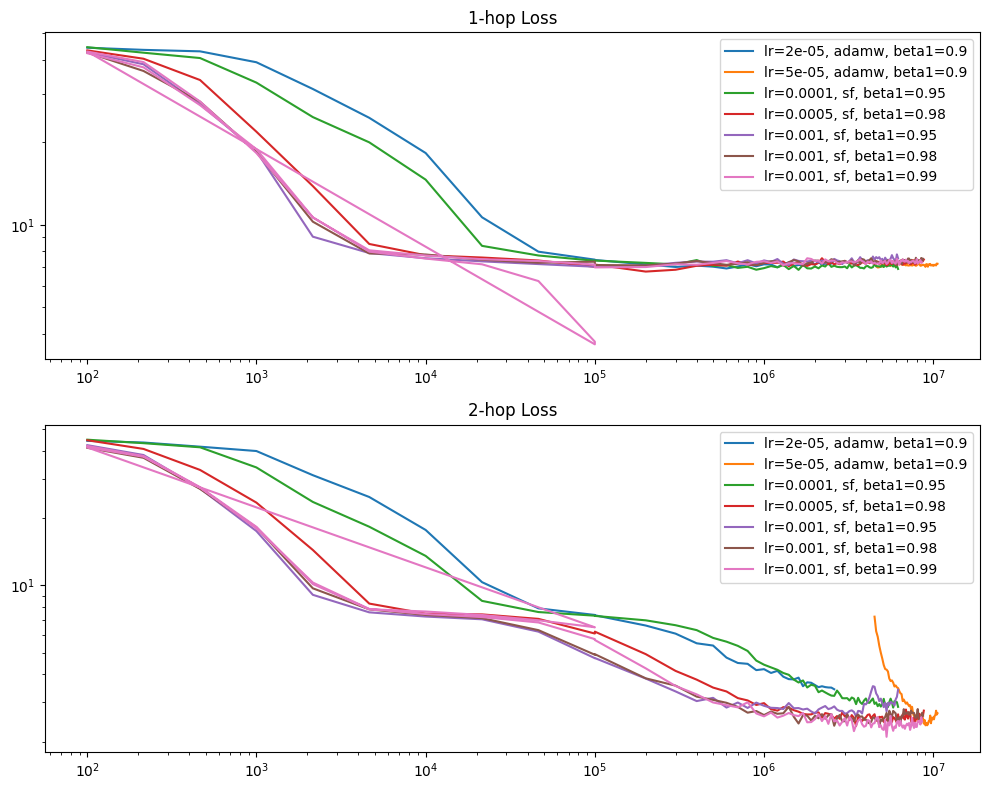

In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Get all eval_results.csv files
files = glob.glob('./results/n10000_p1475824_omin1_omax2_wd0.1_l4_lr*_beta1*_*/eval_results.csv')

def load_results(files):
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        
        # Extract parameters from path
        params = re.search(r'n(\d+)_p(\d+).*lr(.+)_beta1(.+)_(sf|adamw|adamw-linear)', f)
        n_profiles = int(params.group(1))
        n_params = int(params.group(2))
        lr = float(params.group(3))
        beta1 = float(params.group(4))
        optimizer = params.group(5)
        
        # Add columns
        df['N_profiles'] = n_profiles
        df['n_params'] = n_params
        df['hops'] = [1,2] * (len(df)//2)
        df['lr'] = lr
        df['optimizer'] = optimizer
        df['beta1'] = beta1
        
        dfs.append(df)

    df = pd.concat(dfs)
    return df

def plot_loss_over_time(df_filtered):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

    for (lr, opt, beta), group in df_filtered.groupby(['lr', 'optimizer', 'beta1']):
        label = f'lr={lr}, {opt}, beta1={beta}'
        
        hop1 = group[group.hops == 1]
        hop2 = group[group.hops == 2]
        
        ax1.plot(hop1.global_step, hop1.loss, label=label)
        ax2.plot(hop2.global_step, hop2.loss, label=label)

    ax1.set_title('1-hop Loss')
    ax2.set_title('2-hop Loss') 
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

def plot_loss_over_time_by_n_params(df_filtered):
    fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2, figsize=(10,24))

    for (n_params), group in df_filtered.groupby(['n_params']):
        label = f'n_params={n_params}'
        
        hop1 = group[group.hops == 1]
        hop2 = group[group.hops == 2]

        N10000_hop1 = hop1[hop1.N_profiles == 10000]
        N10000_hop2 = hop2[hop2.N_profiles == 10000]
        N25000_hop1 = hop1[hop1.N_profiles == 25000]
        N25000_hop2 = hop2[hop2.N_profiles == 25000]
        N30000_hop1 = hop1[hop1.N_profiles == 30000]
        N30000_hop2 = hop2[hop2.N_profiles == 30000]
        N50000_hop1 = hop1[hop1.N_profiles == 50000]
        N50000_hop2 = hop2[hop2.N_profiles == 50000]
        
        ax11.plot(N10000_hop1.global_step, N10000_hop1.loss, label=label)
        ax12.plot(N10000_hop2.global_step, N10000_hop2.loss, label=label)
        ax21.plot(N25000_hop1.global_step, N25000_hop1.loss, label=label)
        ax22.plot(N25000_hop2.global_step, N25000_hop2.loss, label=label)
        ax31.plot(N30000_hop1.global_step, N30000_hop1.loss, label=label)
        ax32.plot(N30000_hop2.global_step, N30000_hop2.loss, label=label)
        ax41.plot(N50000_hop1.global_step, N50000_hop1.loss, label=label)
        ax42.plot(N50000_hop2.global_step, N50000_hop2.loss, label=label)

    ax11.set_title('1-hop Loss, 10k profiles')
    ax12.set_title('2-hop Loss, 10k profiles')
    ax21.set_title('1-hop Loss, 25k profiles')
    ax22.set_title('2-hop Loss, 25k profiles')
    ax31.set_title('1-hop Loss, 30k profiles')
    ax32.set_title('2-hop Loss, 30k profiles')
    ax41.set_title('1-hop Loss, 50k profiles')
    ax42.set_title('2-hop Loss, 50k profiles')
    ax11.set_xscale('log')
    ax12.set_xscale('log')
    ax21.set_xscale('log')
    ax22.set_xscale('log')
    ax31.set_xscale('log')
    ax32.set_xscale('log')
    ax41.set_xscale('log')
    ax42.set_xscale('log')
    ax11.set_yscale('log')
    ax12.set_yscale('log')
    ax21.set_yscale('log')
    ax22.set_yscale('log')
    ax31.set_yscale('log')
    ax32.set_yscale('log')
    ax41.set_yscale('log')
    ax42.set_yscale('log')
    ax11.legend()
    ax12.legend()
    ax21.legend()
    ax22.legend()
    ax31.legend()
    ax32.legend()
    ax41.legend()
    ax42.legend()
    plt.tight_layout()
    plt.show()

def plot_min_loss_steps(df, early_convergence_threshold=0.9, loss_threshold=0.01):
    """
    Plot first steps where loss is within threshold of minimum, with filtering for early convergence.
    Includes rolling mean smoothing and linear regression analysis.
    """
    # First smooth the loss curves
    df = df.copy()
    df['loss'] = df.groupby(['N_profiles', 'n_params', 'hops'])['loss'].transform(
        lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
    )
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # For each group, find first step within threshold of minimum
    def get_threshold_step(group):
        min_loss = group['loss'].min()
        threshold = min_loss * (1 + loss_threshold)
        first_good_step = group[group['loss'] <= threshold]['global_step'].iloc[0]
        return pd.Series({
            'min_loss_step': first_good_step,
            'max_step': group['global_step'].max(),
            'min_loss': min_loss
        })
    
    min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(get_threshold_step).reset_index()
    
    # Filter for early convergence
    min_loss_data = min_loss_data[
        min_loss_data.min_loss_step < early_convergence_threshold * min_loss_data.max_step
    ]
    
    # Plot vs n_profiles with regression
    for hop in [1,2]:
        hop_data = min_loss_data[min_loss_data.hops == hop]
        
        # Get mean for each N_profiles
        stats = hop_data.groupby('N_profiles')['min_loss_step'].agg(['mean', 'std', 'count']).reset_index()
        
        # Linear regression on log-transformed data
        X = np.log(stats.N_profiles.values.reshape(-1, 1))
        y = np.log(stats['mean'].values)
        reg = LinearRegression().fit(X, y)
        slope = reg.coef_[0]
        r2 = reg.score(X, y)
        
        label = f'{hop}-hop (slope={slope:.2f}, R²={r2:.2f}, n={stats["count"].sum()})'
        ax1.errorbar(stats.N_profiles, stats['mean'], yerr=stats['std'], 
                    label=label, fmt='o-', capsize=5)
        
        # Plot regression line
        x_range = np.linspace(stats.N_profiles.min(), stats.N_profiles.max(), 100)
        y_pred = np.exp(reg.predict(np.log(x_range.reshape(-1, 1))))
        ax1.plot(x_range, y_pred, '--', alpha=0.5)
        
        # Print detailed stats
        print(f"\n{hop}-hop results by N_profiles:")
        print(stats.to_string(index=False))
    
    # Plot vs n_params
    for hop in [1,2]:
        hop_data = min_loss_data[min_loss_data.hops == hop]
        
        # Get mean and std for each n_params
        stats = hop_data.groupby('n_params')['min_loss_step'].agg(['mean', 'std', 'count']).reset_index()
        
        # Linear regression on log-transformed data
        X = np.log(stats.n_params.values.reshape(-1, 1))
        y = np.log(stats['mean'].values)
        reg = LinearRegression().fit(X, y)
        slope = reg.coef_[0]
        r2 = reg.score(X, y)
        
        label = f'{hop}-hop (slope={slope:.2f}, R²={r2:.2f}, n={stats["count"].sum()})'
        ax2.errorbar(stats.n_params, stats['mean'], yerr=stats['std'],
                    label=label, fmt='o-', capsize=5)
        
        # Plot regression line
        x_range = np.linspace(stats.n_params.min(), stats.n_params.max(), 100)
        y_pred = np.exp(reg.predict(np.log(x_range.reshape(-1, 1))))
        ax2.plot(x_range, y_pred, '--', alpha=0.5)
    
    ax1.set_xlabel('Number of Profiles')
    ax1.set_ylabel('Steps to Near-Minimum Loss')
    ax1.set_title(f'Convergence Time vs Dataset Size\n(within {loss_threshold:.1%} of minimum)')
    ax1.legend()
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    ax2.set_xlabel('Number of Parameters')
    ax2.set_ylabel('Steps to Near-Minimum Loss') 
    ax2.set_title(f'Convergence Time vs Model Size\n(within {loss_threshold:.1%} of minimum)')
    ax2.legend()
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

df = load_results(files)

mask = (
    ((df.optimizer == 'adamw') & (df.lr.isin([0.00005, 2e-5]))) |
    ((df.optimizer == 'sf') & (df.beta1 >= 0.98)) |
    ((df.optimizer == 'sf') & (df.beta1 == 0.95) & (df.lr.isin([0.0001, 0.001])))
)
df_filtered = df[mask]

plot_loss_over_time(df_filtered)

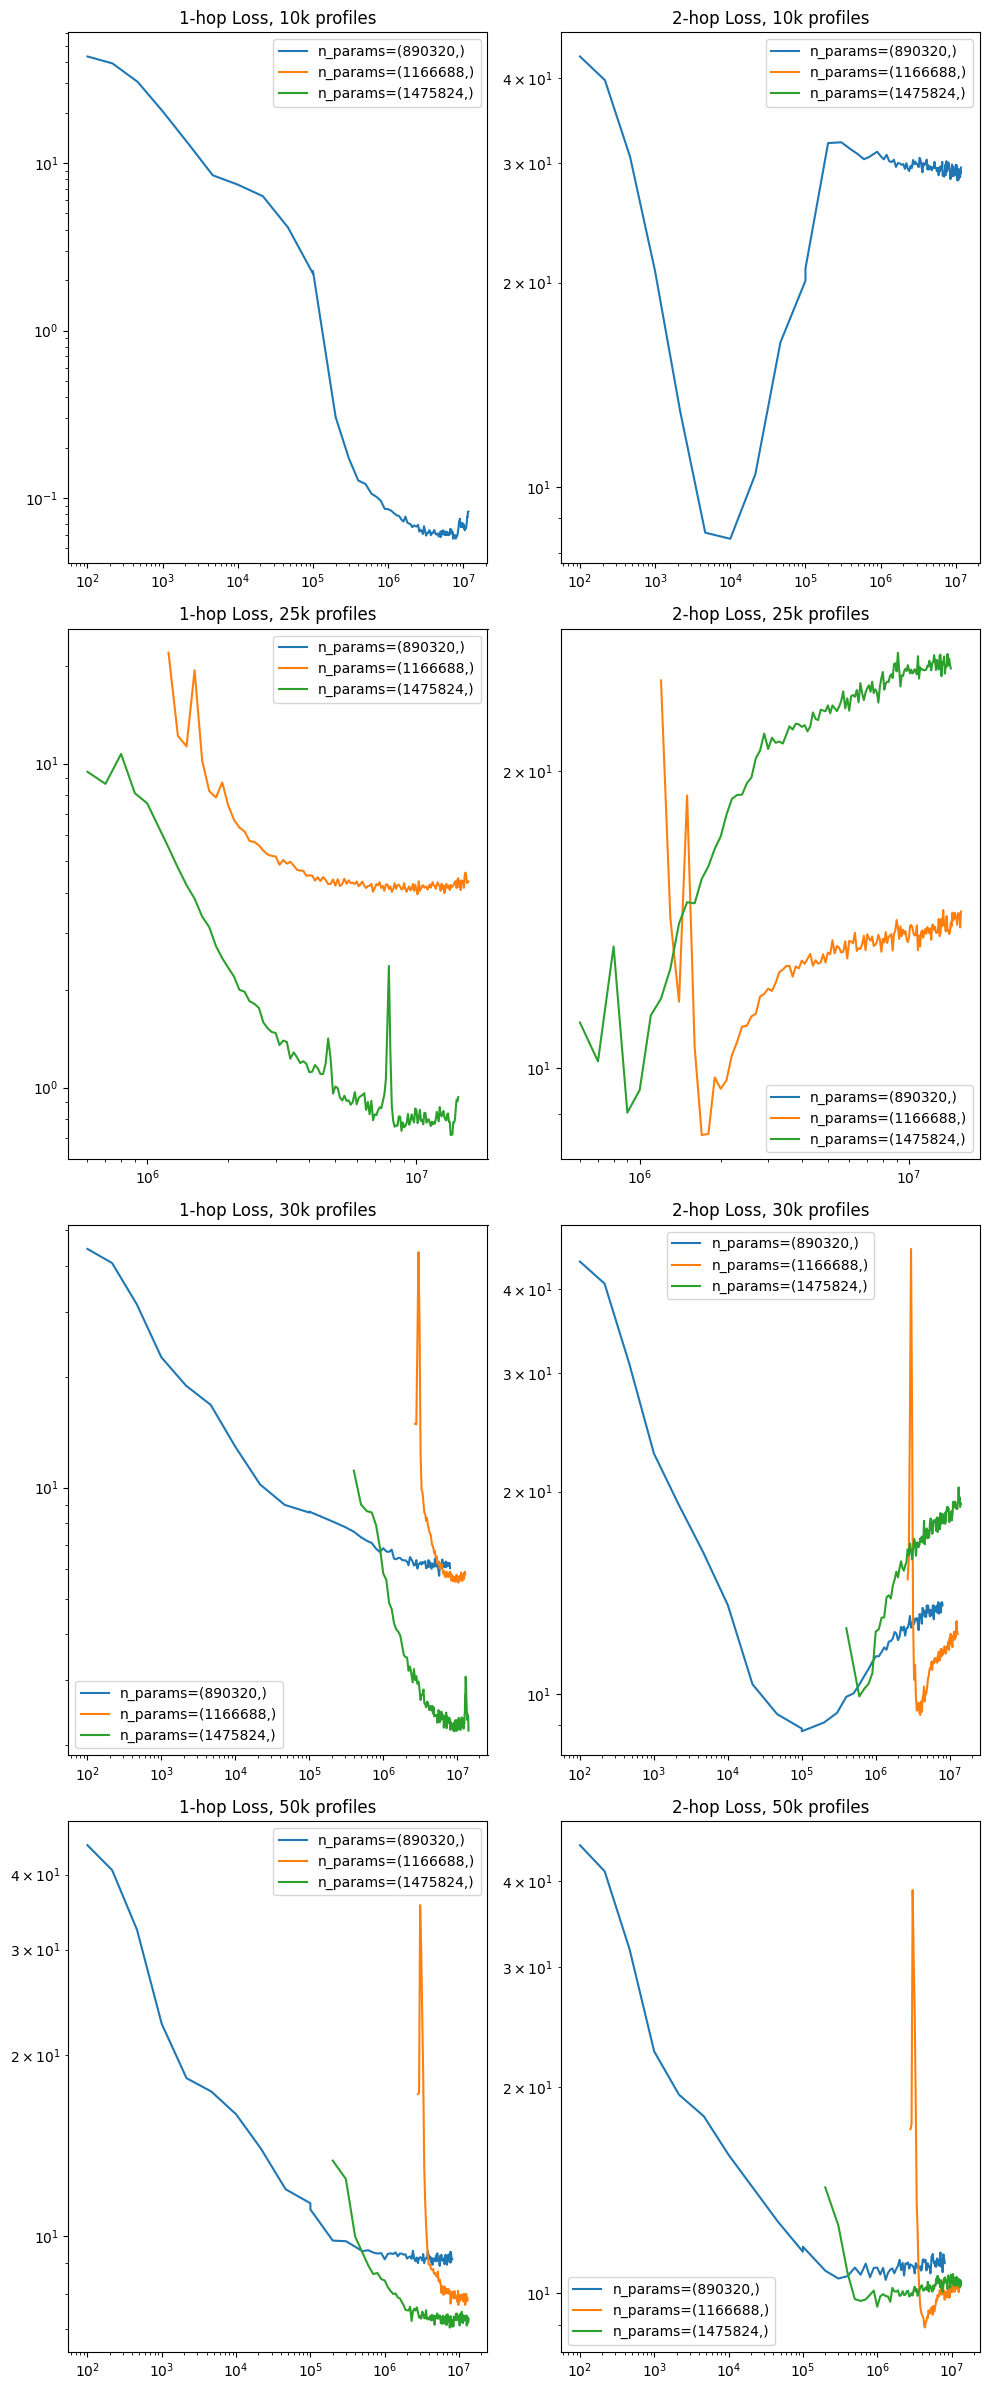

In [2]:

files = glob.glob('./results/n*_p*_omin1_omax1_wd0.1_l4_lr0.001_beta10.99_sf/eval_results.csv')

df = load_results(files)

mask = (
    (df.optimizer == 'sf') & (df.beta1 == 0.99) & ((df.n_params != 1475824) | (df.N_profiles != 10000))
)
df_filtered = df[mask]

plot_loss_over_time_by_n_params(df_filtered)

/tmp/ipykernel_1123745/3136377568.py:147: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(get_threshold_step).reset_index()



1-hop results by N_profiles:
 N_profiles         mean          std  count
      10000 7.500000e+06          NaN      1
      15000 8.250000e+06 1.343503e+06      2
      20000 1.260000e+07          NaN      1
      25000 8.000000e+06          NaN      1
      30000 6.933333e+06 4.423046e+06      3
      50000 6.166667e+06 4.067350e+06      3

2-hop results by N_profiles:
 N_profiles         mean          std  count
      10000 1.000000e+04          NaN      1
      15000 1.550000e+05 2.050610e+05      2
      20000 6.821383e+05 6.805205e+05      3
      25000 1.350000e+06 7.778175e+05      2
      30000 1.533333e+06 1.985783e+06      3
      50000 1.766667e+06 2.112660e+06      3


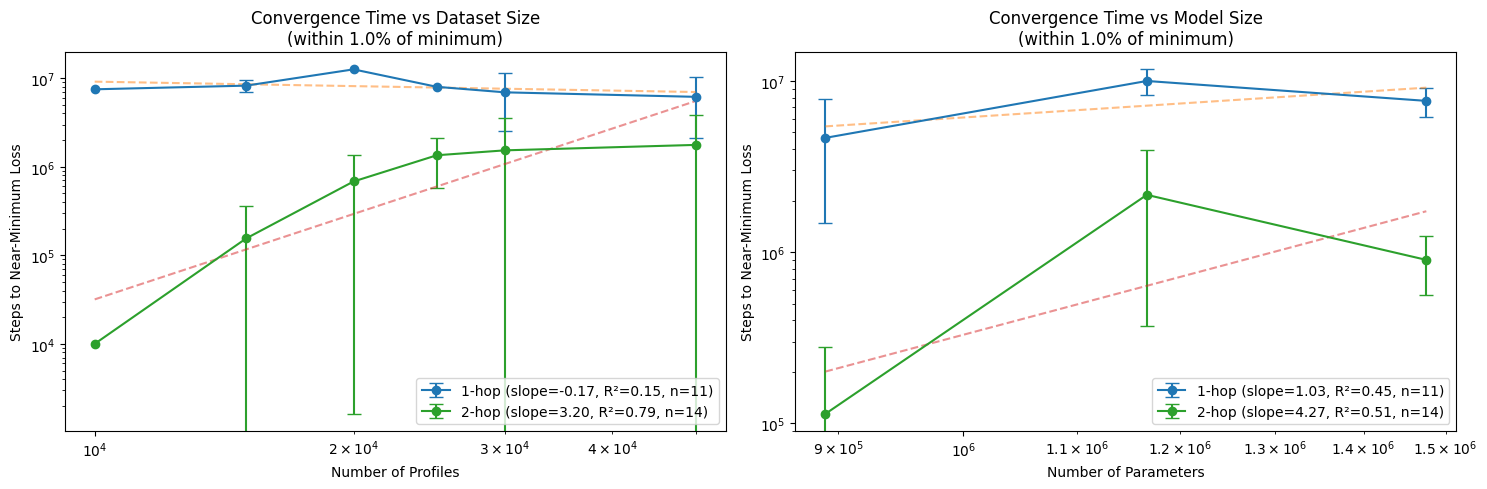

In [58]:
plot_min_loss_steps(df_filtered)

/tmp/ipykernel_1123745/3136377568.py:147: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(get_threshold_step).reset_index()



1-hop results by N_profiles:
 N_profiles         mean           std  count
      10000 1.000000e+05      0.000000      2
      15000 1.999997e+05 100000.500000      3
      20000 3.500000e+05 212132.034356      2
      25000 5.000000e+05 173205.080757      3
      30000 6.666667e+05 251661.147842      3
      50000 1.066667e+06 305505.046330      3

2-hop results by N_profiles:
 N_profiles         mean          std  count
      10000 5.200000e+06 1.555635e+06      2
      15000 3.466667e+06 2.218859e+06      3
      20000 6.650000e+06 1.484924e+06      2
      25000 4.266667e+06 2.458319e+06      3
      30000 2.566667e+06 1.537314e+06      3
      50000 2.200000e+06 1.058301e+06      3


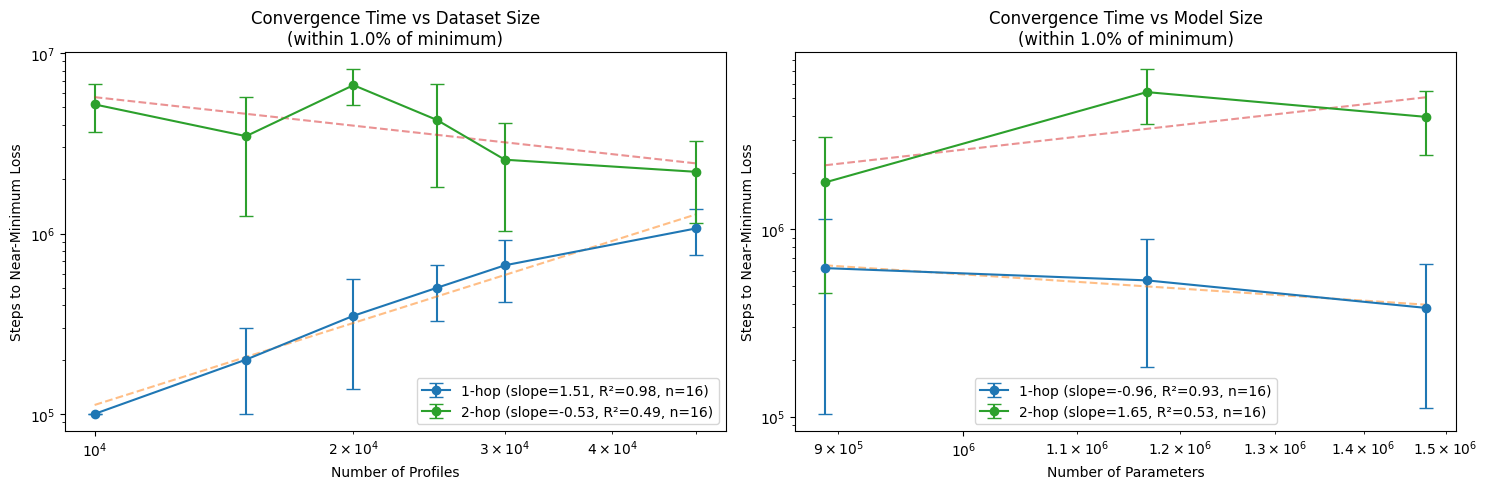

In [59]:
files = glob.glob('./results/n*_p*_omin1_omax2_wd0.1_l4_lr0.001_beta10.99_sf/eval_results.csv')

df = load_results(files)

mask = (
    (df.optimizer == 'sf') & (df.beta1 == 0.99) & ((df.n_params != 1475824) | (df.N_profiles != 10000))
)
df_filtered = df[mask]

plot_min_loss_steps(df_filtered)

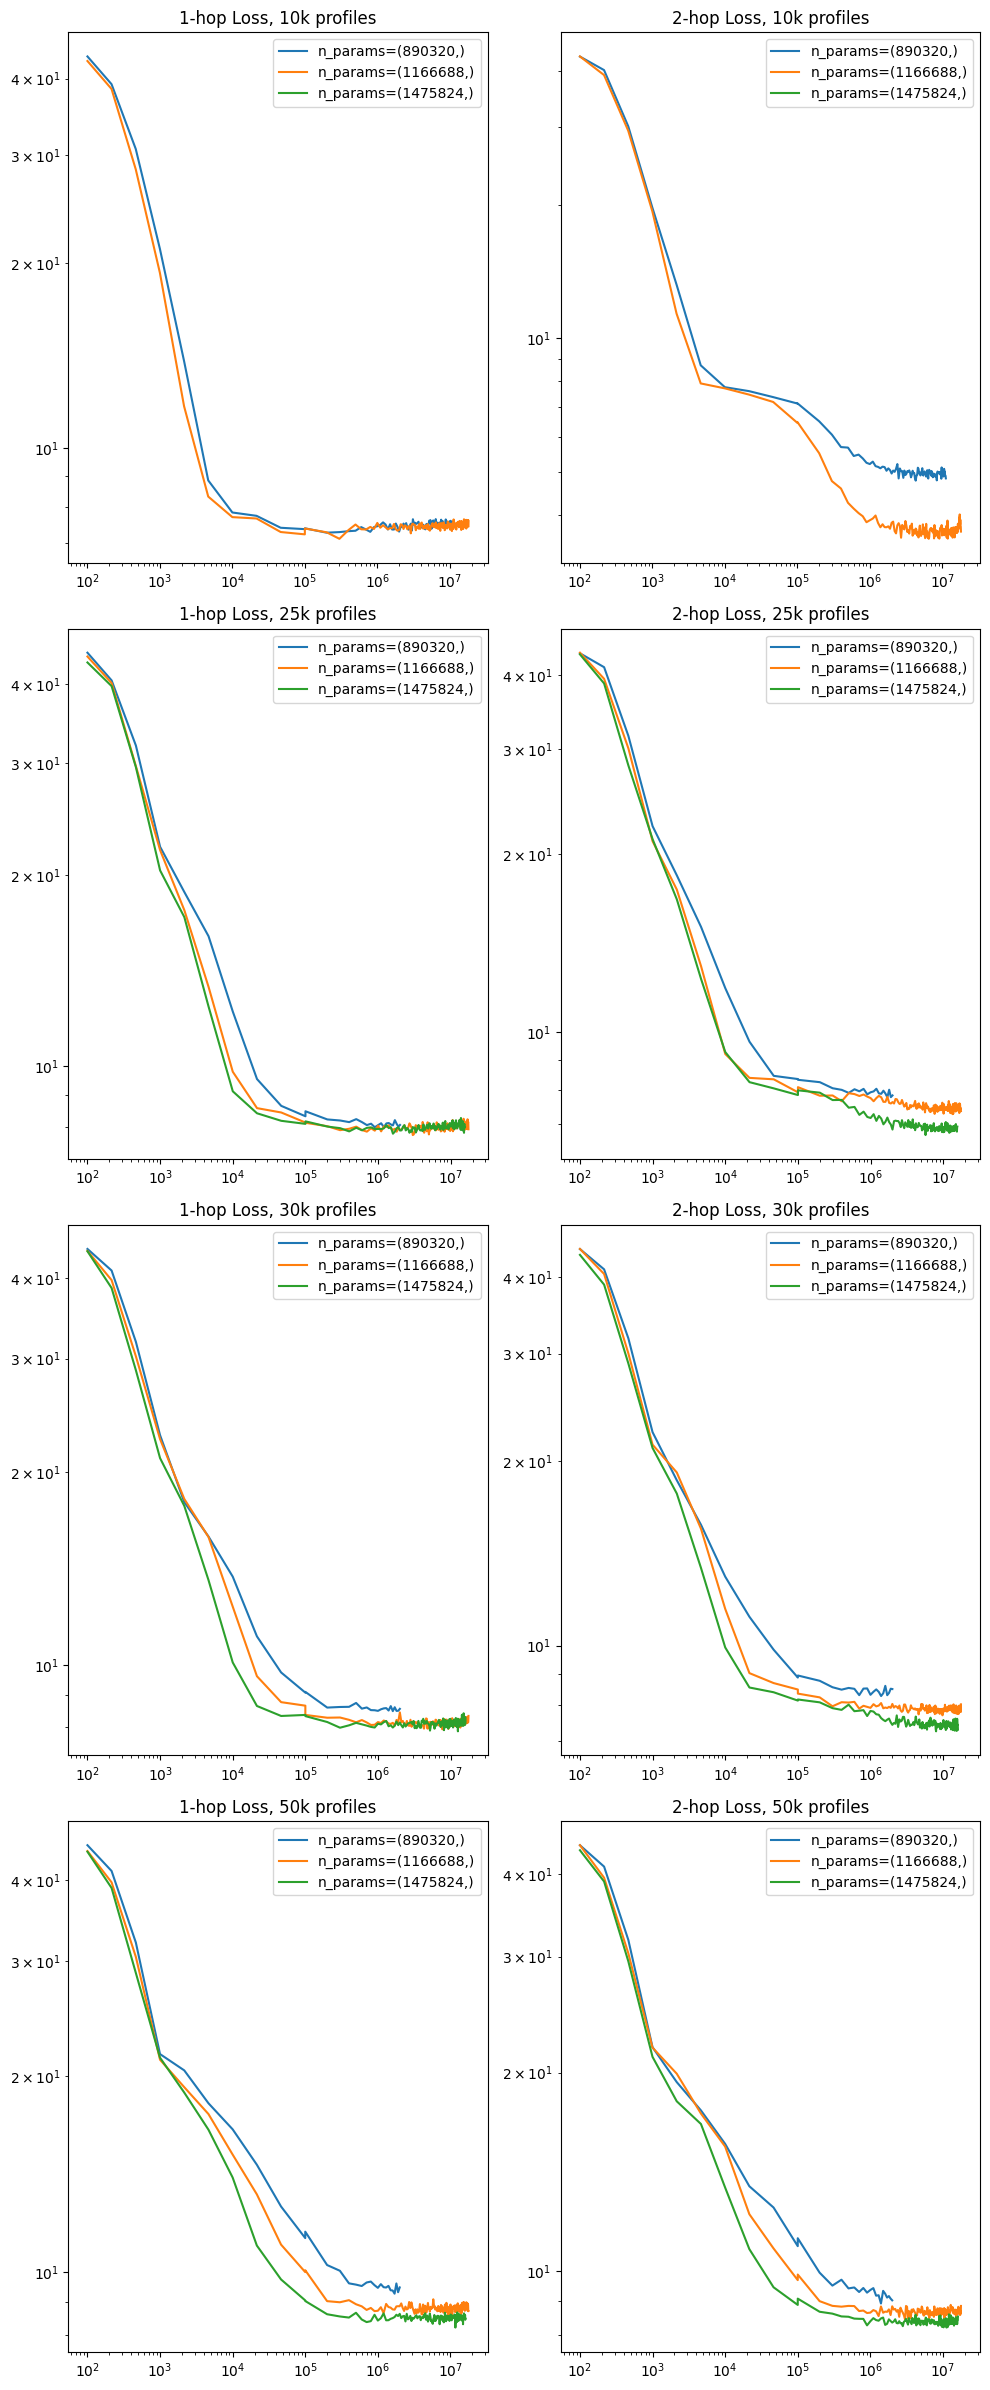

In [55]:
files = glob.glob('./results/n*_p*_omin1_omax2_wd0.1_l4_lr0.001_beta10.99_sf/eval_results.csv')

df = load_results(files)

mask = (
    (df.optimizer == 'sf') & (df.beta1 == 0.99) & ((df.n_params != 1475824) | (df.N_profiles != 10000))
)
df_filtered = df[mask]
plot_loss_over_time_by_n_params(df_filtered)

In [36]:
def analyze_convergence_scaling(df, early_convergence_threshold=0.9):
    """
    Analyze how convergence time scales with both N_profiles and n_params together
    using multiple regression on log-transformed data.
    """
    # Smooth loss curves
    df = df.copy()
    df['loss'] = df.groupby(['N_profiles', 'n_params', 'hops'])['loss'].transform(
        lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
    )
    
    # Get min loss steps
    min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(
        lambda x: pd.Series({
            'min_loss_step': x.loc[x.loss.idxmin()].global_step,
            'max_step': x.global_step.max()
        })
    ).reset_index()
    
    # Filter for early convergence
    min_loss_data = min_loss_data[
        min_loss_data.min_loss_step < early_convergence_threshold * min_loss_data.max_step
    ]
    
    results = {}
    for hop in [1, 2]:
        hop_data = min_loss_data[min_loss_data.hops == hop]
        
        # Prepare data for multiple regression
        X = np.column_stack([
            np.log(hop_data.N_profiles.values),
            np.log(hop_data.n_params.values)
        ])
        y = np.log(hop_data.min_loss_step.values)
        
        # Fit regression
        reg = LinearRegression().fit(X, y)
        r2 = reg.score(X, y)
        
        results[f'{hop}-hop'] = {
            'N_profiles_coef': reg.coef_[0],
            'n_params_coef': reg.coef_[1],
            'intercept': reg.intercept_,
            'R²': r2,
            'n_samples': len(hop_data)
        }
        
    return pd.DataFrame(results).T

analyze_convergence_scaling(df_filtered)

/tmp/ipykernel_1123745/1420387816.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(


,N_profiles_coef,n_params_coef,intercept,R²,n_samples
1-hop,2.24124,0.086846,-9.746880,0.655676,14.0
2-hop,0.11934,2.798241,-24.625727,0.543802,14.0


In [37]:
analyze_convergence_scaling(df_filtered, early_convergence_threshold=1)

/tmp/ipykernel_1123745/1420387816.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(


,N_profiles_coef,n_params_coef,intercept,R²,n_samples
1-hop,2.241240,0.086846,-9.746880,0.655676,14.0
2-hop,0.073697,3.052653,-27.755513,0.601705,15.0


In [41]:
files = glob.glob('./results/n*_p*_omin1_omax1_wd0.1_l4_lr0.001_beta10.99_sf/eval_results.csv')

df = load_results(files)

mask = (
    (df.optimizer == 'sf') & (df.beta1 == 0.99) & ((df.n_params != 1475824) | (df.N_profiles != 10000))
)
df_filtered = df[mask]

analyze_convergence_scaling(df_filtered)


/tmp/ipykernel_1123745/1420387816.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(


,N_profiles_coef,n_params_coef,intercept,R²,n_samples
1-hop,-0.027228,0.160657,14.073903,0.018653,8.0
2-hop,1.964759,5.173645,-79.205558,0.686124,14.0


In [46]:
analyze_convergence_scaling(df_filtered, early_convergence_threshold=1)

/tmp/ipykernel_1123745/1420387816.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_loss_data = df.groupby(['N_profiles', 'n_params', 'hops']).apply(


,N_profiles_coef,n_params_coef,intercept,R²,n_samples
1-hop,0.046162,0.247169,12.187613,0.114414,10.0
2-hop,1.964759,5.173645,-79.205558,0.686124,14.0


In [48]:
def get_tsteps_1hop(n_params, n_profiles):
    return np.exp(0.2 * np.log(n_params) + 13)

def get_tsteps_2hop(n_params, n_profiles):
    return np.exp(0.1 * np.log(n_profiles) + 2.8 * np.log(n_params) - 27)


In [19]:
with open('results/n10000_p4848912_omin1_omax2_wd0.1_l12_lr0.001_beta10.99_sf_r17/eval_results.csv', 'r') as f:
    lines = f.readlines()

# Find where format changes from 3 to 4 columns
three_col_lines = []
four_col_lines = []

header = lines[0]  # Save header
for line in lines[1:]:  # Skip header
    if len(line.strip().split(',')) == 3:
        three_col_lines.append(line)
    else:
        four_col_lines.append(line)

# Create temporary files for each format
with open('temp_3col.csv', 'w') as f:
    f.write(header)
    f.writelines(three_col_lines)
    
with open('temp_4col.csv', 'w') as f:
    f.write("loss,global_step,mode,parameter_l2\n")
    f.writelines(four_col_lines)

# Read each format separately
df_3col = pd.read_csv('temp_3col.csv')
df_4col = pd.read_csv('temp_4col.csv')

# Clean up temporary files
import os
os.remove('temp_3col.csv')
os.remove('temp_4col.csv')

In [24]:
df_3col_plot = df_3col[1::2]
df_4col_plot = df_4col[df_4col['mode'] == 'train_twohop']

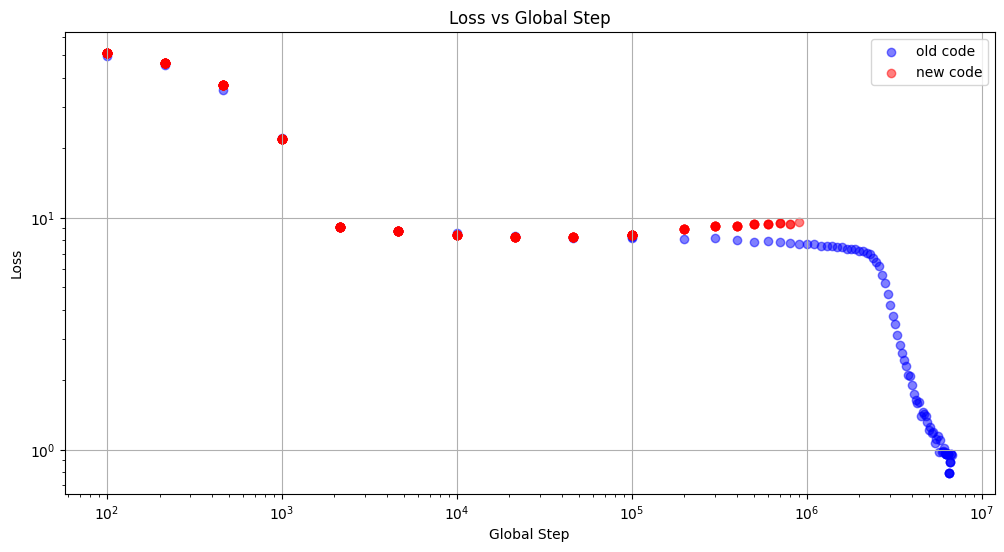

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot df_3col points
plt.scatter(df_3col_plot['global_step'], df_3col_plot['loss'], 
           alpha=0.5, label='old code', color='blue')

# Plot df_4col points
plt.scatter(df_4col_plot['global_step'], df_4col_plot['loss'], 
           alpha=0.5, label='new code', color='red')


plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.title('Loss vs Global Step')
plt.legend()
plt.yscale('log')  # Since loss values often work better on log scale
plt.xscale('log')
plt.grid(True)
plt.show()

In [18]:
df_4col.columns

Index(['loss', ' global_step', ' mode', ' parameter_l2'], dtype='object')

In [20]:
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformer_reasoning.train.train_utils import InfiniteQADataset

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/llama_multihop_tokenizer')

# Load profiles dataset
rel_str = '_r17' # For 2 relations, or '' for default
profiles = load_dataset(f"EleutherAI/profiles_dataset_1000_uniform{rel_str}", keep_in_memory=True)['train']

# Create dataset
dataset = InfiniteQADataset(
    profiles_dataset=profiles,
    tokenizer=tokenizer, 
    max_seq_len=512,
    orders=[1, 2],
    hop_ratio = 0.5 # For 1-hop questions
)

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=4
)

# Get a batch
batch = next(iter(dataloader))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Dataset iterator called with epoch 0


In [21]:
inp_ids = []
inp_id_sentence = []
for c in batch['input_ids'][0][1:]:
    if c == 0:
        inp_ids.append(inp_id_sentence)
        inp_id_sentence = []
    else:
        inp_id_sentence.append(c.item())

inp_ids

[[340,
  16,
  92,
  89,
  2309,
  349,
  1023,
  44,
  1830,
  72,
  74,
  100,
  205,
  204,
  248,
  102,
  72,
  74,
  130,
  168,
  17,
  93,
  16,
  715,
  175,
  729,
  4,
  196,
  301],
 [340,
  16,
  92,
  89,
  2809,
  377,
  700,
  1908,
  1445,
  49,
  2752,
  74,
  71,
  2215,
  102,
  71,
  63,
  651,
  74,
  100,
  211,
  1910,
  127,
  63,
  381,
  17,
  93,
  16,
  216,
  449,
  409,
  2646,
  1110,
  180,
  94],
 [340,
  16,
  92,
  89,
  97,
  1856,
  2101,
  1894,
  420,
  101,
  412,
  2340,
  74,
  100,
  211,
  1910,
  127,
  63,
  381,
  74,
  100,
  154,
  178,
  159,
  17,
  93,
  16,
  1463,
  187,
  893,
  44,
  155,
  247,
  45,
  105],
 [340,
  16,
  92,
  89,
  855,
  377,
  894,
  107,
  267,
  584,
  1133,
  74,
  71,
  46,
  1484,
  99,
  74,
  71,
  1226,
  45,
  284,
  17,
  93,
  16,
  1071,
  1667,
  350,
  438,
  385,
  334,
  69,
  653],
 [340,
  16,
  92,
  89,
  612,
  48,
  800,
  48,
  58,
  875,
  810,
  74,
  166,
  17,
  93,
  16,
  1710,


In [26]:
text = batch['text'][0].split('<|endoftext|>')

In [13]:
len(inp_ids), len(text)

(19, 34)

In [31]:
inp_ids[4], text[4]

([340,
  16,
  92,
  89,
  612,
  48,
  800,
  48,
  58,
  875,
  810,
  74,
  166,
  17,
  93,
  16,
  1710,
  510],
 "Question: What was Pete Romeo Haitz's employer? Answer: Salim Group")

In [1]:
from transformer_reasoning.evaluation.eval_utils import get_sizes_and_entropies
df = get_sizes_and_entropies()
df

TypeError: tuple indices must be integers or slices, not str